In [1]:
import eland as ed
import numpy as np
import matplotlib.pyplot as plt
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
%%capture
ticker="META"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_bbands = ed.eland_to_pandas(df_eod).sort_values(by='date_reference', ascending=True).tail(100).set_index('date_reference')

In [4]:
# Reference: https://www.fmlabs.com/reference/default.htm?url=Bollinger.htm

period = 20
std_dev = 2

# Calculate Typical Price (TP)
df_bbands['tp'] = (df_bbands['val_high'] + df_bbands['val_low'] + df_bbands['val_close']) / 3

# Calculate Middle Band (SMA of TP)
df_bbands['middle_band'] = df_bbands['tp'].rolling(window=period).mean()

# Calculate Standard Deviation of TP
df_bbands['sd'] = df_bbands['tp'].rolling(window=period).std()

# Calculate Upper and Lower Bands
df_bbands['upper_band'] = df_bbands['middle_band'] + (std_dev * df_bbands['sd'])
df_bbands['lower_band'] = df_bbands['middle_band'] - (std_dev * df_bbands['sd'])

# Calculate Band Width (%)
df_bbands['band_width'] = ((df_bbands['upper_band'] - df_bbands['lower_band']) / df_bbands['middle_band']) * 100

# Drop NaN rows (due to rolling windows)
df_bbands.dropna(inplace=True)

In [5]:
df_bbands.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,tp,middle_band,sd,upper_band,lower_band,band_width
date_reference,,,,,,,,,,,,
2025-10-17,META,716.915,718.54,706.12,707.075,12232441,713.858333,728.200988,19.493139,767.187266,689.214711,10.707560
2025-10-20,META,732.170,733.77,720.18,721.190,8900204,728.706667,726.046988,16.586959,759.220906,692.873071,9.138229
2025-10-21,META,733.270,738.50,728.75,736.015,7647269,733.506667,724.771155,14.802328,754.375811,695.166499,8.169380
2025-10-22,META,733.410,740.60,724.03,733.830,8734491,732.680000,723.500237,12.737453,748.975143,698.025331,7.042128
2025-10-23,META,734.000,742.41,733.10,734.700,9855974,736.503333,722.821653,11.553683,745.929020,699.714287,6.393657


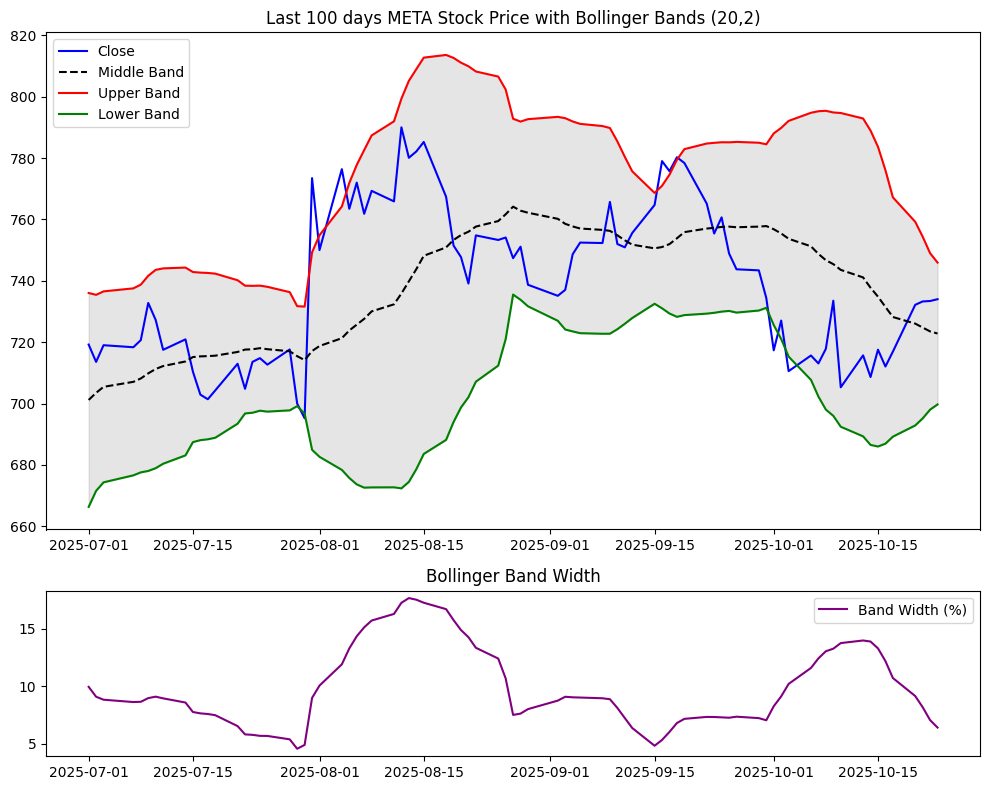

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

# Top: Price with BBANDS
axs[0].plot(df_bbands.index, df_bbands['val_close'], label='Close', color='blue')
axs[0].plot(df_bbands.index, df_bbands['middle_band'], label='Middle Band', color='black', linestyle='--')
axs[0].plot(df_bbands.index, df_bbands['upper_band'], label='Upper Band', color='red')
axs[0].plot(df_bbands.index, df_bbands['lower_band'], label='Lower Band', color='green')
axs[0].fill_between(df_bbands.index, df_bbands['upper_band'], df_bbands['lower_band'], color='gray', alpha=0.2)
axs[0].set_title(f"Last 100 days {ticker} Stock Price with Bollinger Bands ({period},{std_dev})")
axs[0].legend()

# Bottom: Band Width
axs[1].plot(df_bbands.index, df_bbands['band_width'], label='Band Width (%)', color='purple')
axs[1].set_title('Bollinger Band Width')
axs[1].legend()

plt.tight_layout()
plt.show()

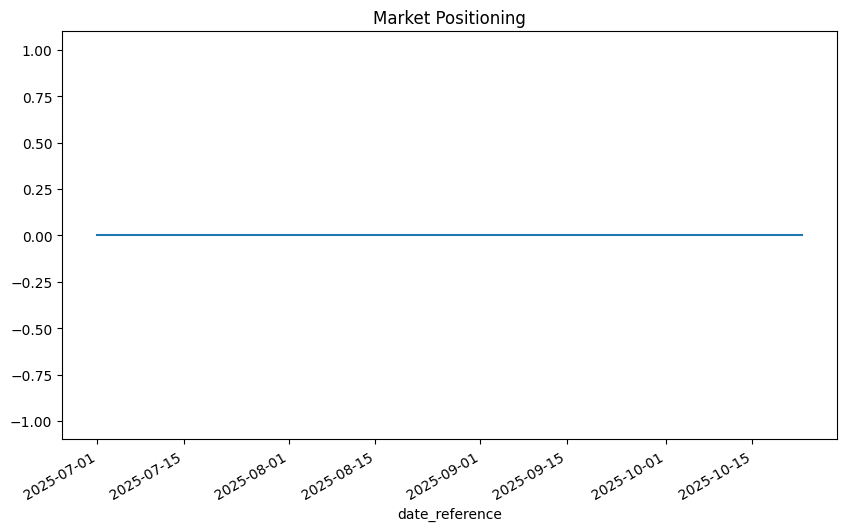

In [7]:
# Generate positions for the strategy (1 for bullish bounce/cross, -1 for bearish, 0 neutral)
df_bbands['prev_close'] = df_bbands['val_close'].shift(1)
df_bbands['prev_middle'] = df_bbands['middle_band'].shift(1)
df_bbands['position'] = 0
# Bullish: Price was below lower, now crosses above middle
df_bbands['position'] = np.where((df_bbands['prev_close'] < df_bbands['lower_band']) &
                                 (df_bbands['prev_close'] < df_bbands['prev_middle']) &
                                 (df_bbands['val_close'] > df_bbands['middle_band']), 1, df_bbands['position'])
# Bearish: Price was above upper, now crosses below middle
df_bbands['position'] = np.where((df_bbands['prev_close'] > df_bbands['upper_band']) &
                                 (df_bbands['prev_close'] > df_bbands['prev_middle']) &
                                 (df_bbands['val_close'] < df_bbands['middle_band']), -1, df_bbands['position'])
df_bbands['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

In [8]:
# Detect key events (price crossing middle, or touching bands)
df_bbands['cross_middle_up'] = (df_bbands['prev_close'] < df_bbands['prev_middle']) & (df_bbands['val_close'] > df_bbands['middle_band'])
df_bbands['cross_middle_down'] = (df_bbands['prev_close'] > df_bbands['prev_middle']) & (df_bbands['val_close'] < df_bbands['middle_band'])
df_bbands['touch_upper'] = (df_bbands['val_close'] >= df_bbands['upper_band'])
df_bbands['touch_lower'] = (df_bbands['val_close'] <= df_bbands['lower_band'])
events = df_bbands[df_bbands['cross_middle_up'] | df_bbands['cross_middle_down'] | df_bbands['touch_upper'] | df_bbands['touch_lower']]
events[['val_close', 'lower_band', 'middle_band', 'upper_band', 'position', 'band_width']]

,val_close,lower_band,middle_band,upper_band,position,band_width
date_reference,,,,,,
2025-07-15,710.390,687.442387,715.150555,742.858723,0,7.748905
2025-07-28,717.630,697.788614,717.045515,736.302416,0,5.371180
2025-07-29,700.000,699.165202,715.447848,731.730495,0,4.551735
2025-07-30,695.210,696.716460,714.157352,731.598243,0,4.884327
2025-07-31,773.440,684.930398,717.107852,749.285306,0,8.974230
2025-08-04,776.370,678.391873,721.301683,764.211493,0,11.897882
2025-08-19,751.480,693.979842,753.299702,812.619561,0,15.749338
2025-09-09,765.700,722.760034,756.271040,789.782046,0,8.862168
2025-09-10,751.980,724.222743,754.814040,785.405337,0,8.105651
